In [12]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import eigen

def openImage(imgPath):
    imgOriginal = Image.open(imgPath)
    im = np.array(imgOriginal)
    imgChannels = []
    bands = imgOriginal.getbands()
    imgAlpha = np.nan
    hasAlphaValue = False
    for band in bands:
        if band == 'A':
            imgAlpha = imgOriginal.getchannel("A")
            hasAlphaValue = True
        else:
            imgChannels.append(imgOriginal.getchannel(band))

    return imgChannels, imgAlpha, hasAlphaValue, imgOriginal, bands


def getSVDMatrices(mat):
    AxAtranspose = mat @ np.transpose(mat)
    AtransposexA = np.transpose(mat) @ mat

    eigenLeft = eigen.get_eigen_values(AxAtranspose)
    eigenRight = eigen.get_eigen_values(AtransposexA)

    U = np.transpose(eigen.get_eigen_vectors(AxAtranspose, eigenLeft))
    S = np.sqrt(eigenLeft)
    VT = eigen.get_eigen_vectors(AtransposexA, eigenRight)


    print(U.shape)
    print(S.shape)
    print(VT.shape)
    return U, S, VT


def compressSingleChannel(channel, r):
    u, s, vt = getSVDMatrices(channel)
    U, S, VT = np.linalg.svd(channel)
    np.savetxt("result.txt", s)
    np.savetxt("real_result.txt", S)
    s = np.diag(s)
    compressed = u[:,:r] @ s[0:r, :r] @ vt[:r, :]
    return compressed.astype('uint8')

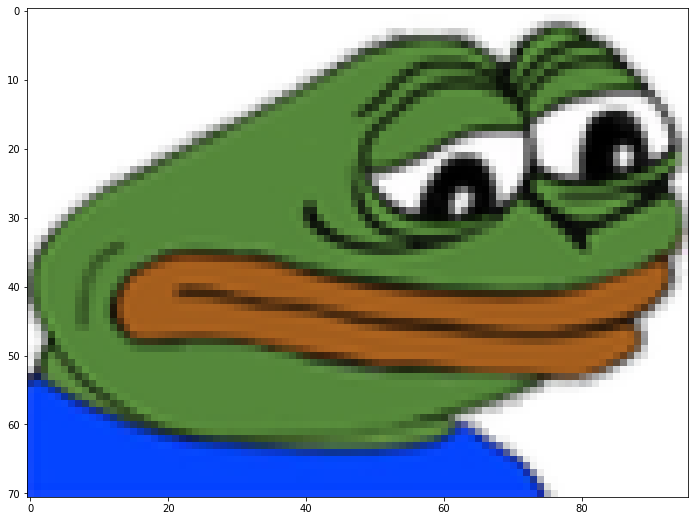

In [13]:
channels, alpha, hasAlpha, original, bands = openImage("sadge.png")
mean = np.mean(original, -1)
plt.figure(figsize=(16, 9))
plt.imshow(original)

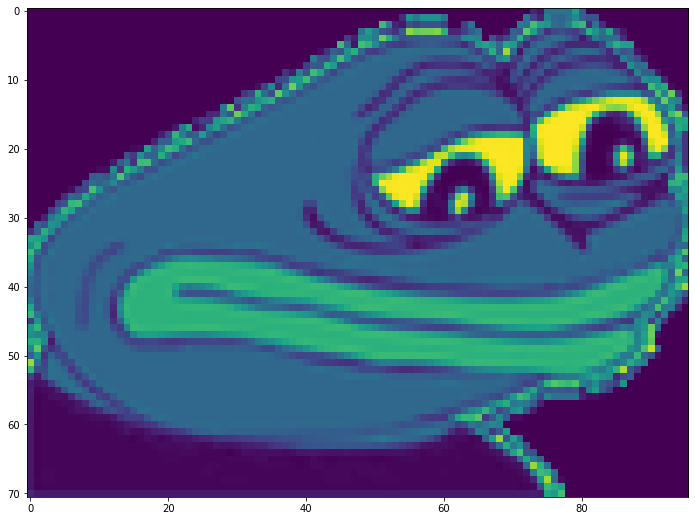

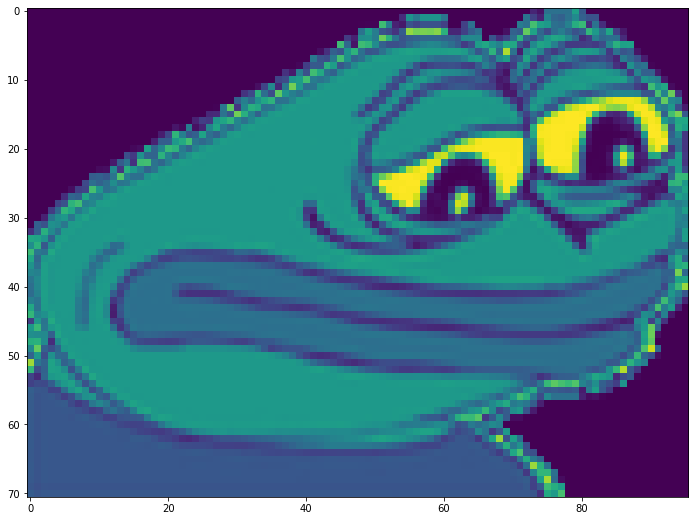

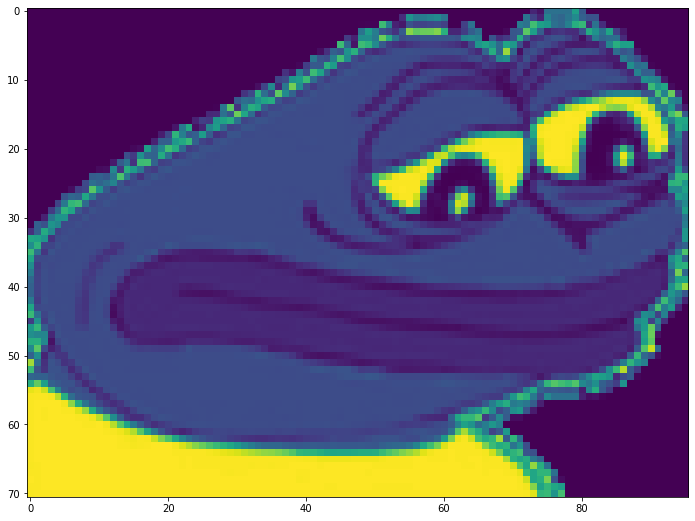

In [14]:
for channel in channels:
    plt.figure(figsize=(16, 9))
    img = plt.imshow(channel)
    plt.show()

r = 5
(71, 71)
(71,)
(96, 96)
(71, 71)

<ipython-input-12-09e804630f9b>:33: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(eigenLeft)



(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)


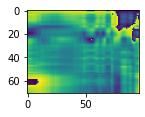

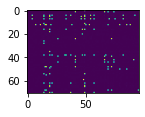

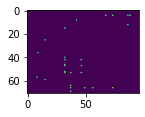

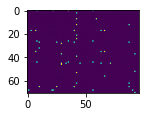

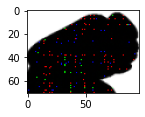

r = 20
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)


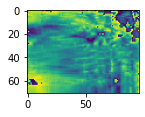

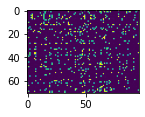

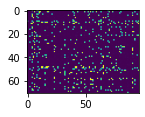

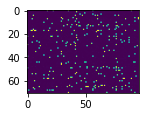

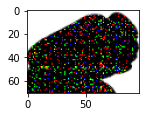

r = 35
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)


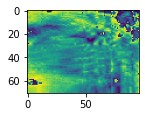

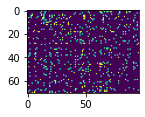

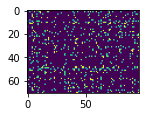

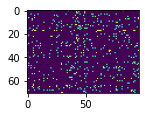

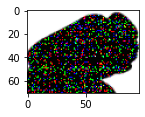

r = 45
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)
(71, 71)
(71,)
(96, 96)


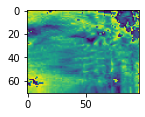

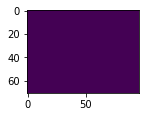

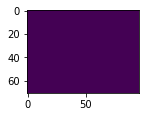

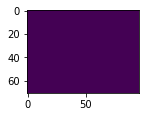

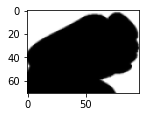

In [15]:
for r in (5, 20, 35, 45):
    print(f"r = {r}")

    compressedMean = compressSingleChannel(mean, r)

    compressedChannels = []
    for channel in channels:
        compressedChannels.append(compressSingleChannel(channel, r))


    compressedImageChannels = []
    for compressedChannel in compressedChannels:
        compressedImageChannels.append(Image.fromarray(compressedChannel, mode=None))

    if hasAlpha:
        compressedImageChannels.append(alpha)

    
    newImage = Image.merge(''.join(bands), tuple(compressedImageChannels))

    plt.figure(figsize=(2, 2))
    img = plt.imshow(compressedMean)
    plt.show()  

    for compressedChannel in compressedChannels:
        plt.figure(figsize=(2, 2))
        img = plt.imshow(compressedChannel)
        plt.show()

    plt.figure(figsize=(2, 2))
    img = plt.imshow(newImage)
    plt.show()